In [1]:
from src import wrapper
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import numpy as np

latency = np.arange(0.001, 0.2, 0.001)
accuracy = np.arange(0.5, 1.0, 0.01)

def diam(latency: float, accuracy: float, sys: str):
    return wrapper.get_max_diam(latency, (1 - accuracy)**2, sys=sys)

systems = ["F1", "CC"]

diameters =[]
# Layer 11 TCP results
for l in latency:
    for a in accuracy:
        for sys in systems:
            diameters.append([l, a, sys, diam(l, a, sys=sys)])

df = pd.DataFrame(diameters, columns=["latency", "accuracy", "system", "diameter"])
df

# Plotting
# for sys in ["F1", "CC"]:
#     for setup in ["l11_tcp", "l15_tcp", "l11_udp", "l15_udp"]:
#         plt.plot(range(1, 6), diameter[sys][setup], label=f"{sys} {setup}", marker="o", lw=4, markersize=15)
#     plt.xticks(range(1, 6), fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.xlabel("Network loss (%)", fontsize=20)
#     plt.ylabel("Max diameter of reachable sets (m)", fontsize=20)
#     # plt.title("Reachability analysis with a simplified cruise control model", fontsize=18)
#     plt.legend(fontsize=15)
#     plt.show()

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


    Updating git-repo `https://github.com/shengjiex98/ControlBenchmarks.jl.git`
   Resolving package versions...
  No Changes to `/opt/homebrew/Caskroom/miniforge/base/envs/ipy/julia_env/Project.toml`
  No Changes to `/opt/homebrew/Caskroom/miniforge/base/envs/ipy/julia_env/Manifest.toml`
    Updating git-repo `https://github.com/shengjiex98/NoisyReach.jl.git`
   Resolving package versions...
  No Changes to `/opt/homebrew/Caskroom/miniforge/base/envs/ipy/julia_env/Project.toml`
  No Changes to `/opt/homebrew/Caskroom/miniforge/base/envs/ipy/julia_env/Manifest.toml`


,latency,accuracy,system,diameter
0,0.001,0.50,F1,2.258538
1,0.001,0.50,CC,4.227256
2,0.001,0.51,F1,2.253987
3,0.001,0.51,CC,4.215012
4,0.001,0.52,F1,2.249685
...,...,...,...,...
19895,0.199,0.97,CC,5.796857
19896,0.199,0.98,F1,2.092707
19897,0.199,0.98,CC,5.795712
19898,0.199,0.99,F1,2.091959


In [4]:
df.to_csv("diameters.csv", index=False)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_scan(sysname: str):
    data = df[df['system'] == sysname]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    latency_vals = data['latency'].values
    accuracy_vals = data['accuracy'].values
    diameter_vals = data['diameter'].values
    minima = np.argmin(diameter_vals)

    surf = ax.plot_trisurf(latency_vals, accuracy_vals, diameter_vals, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    # ax.scatter(latency_vals, accuracy_vals, diameter_vals, marker='o')
    ax.scatter(latency_vals[minima], accuracy_vals[minima], diameter_vals[minima], s=100, marker='o', color='red')

    ax.set_xlabel('Latency')
    ax.set_ylabel('Accuracy')
    ax.set_zlabel('Diameter')

    plt.show()

df = pd.read_csv("diameters.csv")

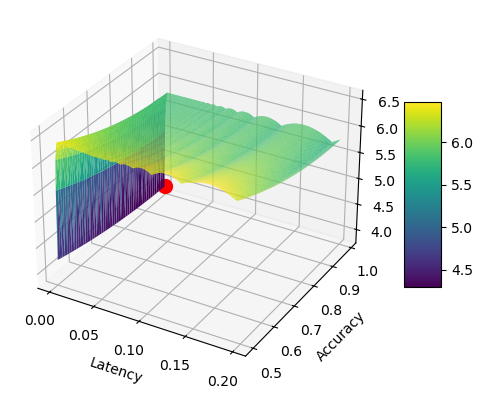

In [25]:
plot_scan("CC")

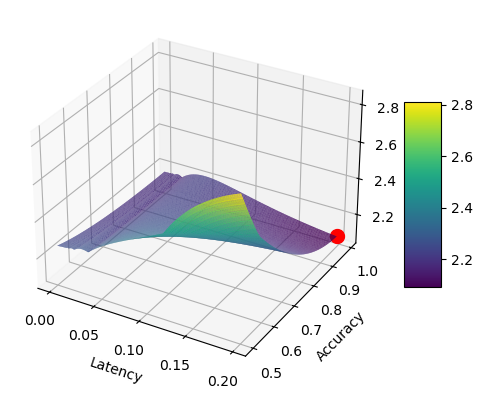

In [26]:
plot_scan("F1")